In [ ]:
!rm -rf gpu_optimization
!git clone https://github.com//Dodilei/gpu_optimization.git

Cloning into 'gpu_optimization'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 43 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 62.84 KiB | 3.93 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
!pip install pycuda

In [ ]:
import pycuda.driver as drv
import pycuda.compiler
from pycuda.gpuarray import vec
import numpy as np
import pycuda.autoinit # This automatically initializes the CUDA driver

# Verify PyCUDA installation
print(f"CUDA driver version: {drv.get_version()}")

# Test if the context was popped by attempting an operation
try:
    # Attempt a simple memory allocation, which requires a valid context
    test_allocation = drv.mem_alloc(np.int32().nbytes)
    print("Context is still active after attempting to pop.")
    # If allocation succeeded, free the memory
    test_allocation.free()
except drv.LogicError as e:
    if "invalid device context" in str(e):
        print("Context was inactive.")
        # Create and push a new context for device 0
        try:
            new_context = drv.Device(0).make_context()
            print("New CUDA context created and activated.")
        except Exception as e:
            print(f"Failed to create new context: {e}")
    else:
        print(f"An unexpected error occurred during context test: {e}")
except Exception as e:
    print(f"An unexpected error occurred during context test: {e}")

# Create two CUDA events
start_event = drv.Event()
end_event = drv.Event()

CUDA driver version: (12, 5, 0)
Context is still active after attempting to pop.
New CUDA context created and activated.


In [ ]:
# --- Define Kernel ---
with open("/content/gpu_optimization/estabilidade1_kernel.cu", "r") as f:
    cuda_kernel_code = f.read()

module = pycuda.compiler.SourceModule(cuda_kernel_code, no_extern_c=True)
estabilidade1_kernel = module.get_function("stage_estabilidade1")

In [ ]:
# Define coefficients as arrays (PyCUDA can marshal these to floatN)
wcl_coeffs = vec.make_float4(*np.array([5.71558580e-01,  6.05864834e-02, -3.00544472e-04, -6.03974299e-05], dtype=np.float32))
wcm_coeffs = vec.make_float3(*np.array([-0.18781341, -0.0006181 ,  0.00030185], dtype=np.float32))

In [ ]:
# Allocate memory for num_vars on the GPU
num_vars = np.array([
    16,
    16,
     8,
     8,
    ], dtype=np.int32)
num_vars_gpu = drv.mem_alloc(num_vars.nbytes)
drv.memcpy_htod(num_vars_gpu, num_vars)

# Allocate memory for scale_params on the GPU
scale_params = np.array([
    4.0/16,
    0.75/16,
    0.25/8,
    2.0/8,
    ], dtype=np.float32)
scale_params_gpu = drv.mem_alloc(scale_params.nbytes)
drv.memcpy_htod(scale_params_gpu, scale_params)

# Allocate memory for const_params on the GPU
const_params = np.array([
     3.0,
     0.25,
     0.1,
     1.5,
    ], dtype=np.float32)
const_params_gpu = drv.mem_alloc(const_params.nbytes)
drv.memcpy_htod(const_params_gpu, const_params)

# Allocate GPU memory for results
size = int(num_vars.prod(dtype=np.int32))
results_gpu = drv.mem_alloc(size * np.float32().nbytes)

In [ ]:
# 3. Launch the kernel
block_size = 256
grid_size = (size + block_size - 1) // block_size

print(f"\n--- Test Launch ---")
print(f"Test size: {size}")
print(f"Test block size: {block_size}")
print(f"Test grid size: {grid_size}")
print(f"Kernel launch: grid=({grid_size}, 1), block=({block_size}, 1, 1)")

start_event.record()

estabilidade1_kernel(
    results_gpu,
    num_vars_gpu,
    scale_params_gpu,
    const_params_gpu,
    wcl_coeffs,
    wcm_coeffs,
    np.float32(0.072),
    np.float32(0.059),
    np.float32(-0.0024),
    np.float32(0.25),
    np.int32(len(num_vars)),
    block=(block_size, 1, 1),
    grid=(grid_size, 1)
)

end_event.record()
end_event.synchronize()
elapsed_time_ms = end_event.time_since(start_event)
print(f"Kernel execution time: {elapsed_time_ms:.3f} ms")

# 4. Copy the data back to the CPU
results_cpu = np.empty(size, dtype=np.float32)
drv.memcpy_dtoh(results_cpu, results_gpu)

print("\nTest results on CPU:", results_cpu)

# Clean up GPU memory
results_gpu.free()
num_vars_gpu.free()
scale_params_gpu.free()
const_params_gpu.free()
print("\nTest GPU memory freed.")


--- Test Launch ---
Test size: 16384
Test block size: 256
Test grid size: 64
Kernel launch: grid=(64, 1), block=(256, 1, 1)
Kernel execution time: 5.073 ms

Minimal test results on CPU: [0.09848937 0.10762276 0.11784481 ... 0.533001   0.5862104  0.63996434]

Minimal test GPU memory freed.


In [ ]:
# Attempt to pop the current context
try:
    pycuda.autoinit.context.pop()
    print("Attempted to pop the previous CUDA context.")
except Exception as e:
    print(f"Could not pop context (likely none was active or manageable by autoinit): {e}")

Attempted to pop the previous CUDA context.


<Axes: ylabel='Count'>

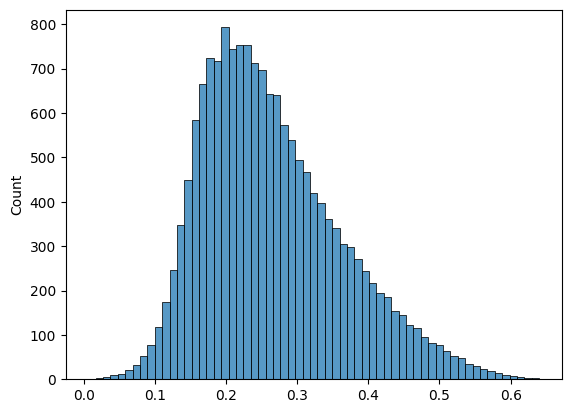

In [ ]:
import seaborn as sns
sns.histplot(results_cpu)#, binrange=(0, 5))